# Oregon Medicaid Experiement
We use the Oregon medicaid dataset (Finkelstein et al., 2012) to illustrate the statistical bound in our paper. In 2008, Oregon instituted a lottery system for choosing low-income adult resident to enroll in the Medicaid program. Due to the nature of the lottery, it simulates a randomized controlled design study. A year later, a comprehensive survey was conducted on both the treatment group (those who had won the lottery) and the control group (those who did not win the lottery). We analyzed the effects of the treatment (L) on two different health outcomes: overall health indicated by a binary self-reported measure of positive (not fair, good, very good, or excellent) or negative (poor), and the number days with good physical or mental health in the past 30 days. After removing all datapoints without entries for each response variable we used $n = 22517$ for the overall health indicator model and $n = 20902$ for the number of days of good health model.  

### Notation
For our analysis we use the following notation:

$z=(x,y)$

$\ell(z,\theta)$ is the loss function

$H_\star = \nabla_{\theta_\star}^2 \ell (\theta_\star)$ is the population Hessian

$H_n(\theta_n) := \frac{1}{n} \sum_{i=1}^n \nabla_{\theta_n}^2 \ell(z_i, \theta_n)$ is the estimate of the Hessian

In [1]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from utils import oregon_medicaid_data, dependent_var_data, if_diff_n_oregon, clean_results_oregon, standardize, bound_values_oregon
import warnings
warnings.filterwarnings('ignore')

# Download and clean data
data_survey12m, depen_var, lottery, fixed_var, dem_eco_var = oregon_medicaid_data(
    "../data/oregon_data/oregonhie_descriptive_vars.dta", "../data/oregon_data/oregonhie_survey12m_vars.dta")


# Empirical Influence Function for Ridge Regression
We define, 

$\ell(z,\theta)= (y - x^T\theta) + \lambda \theta^T \theta$ be the loss function, and $\theta_n$ is calculated using ridge regression.

Then, we use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}\nabla \ell(z,\theta_n)$

We define the following:

$H_n(\theta_n) = \frac1n \sum_{i=1}^n x_ix_i^T + \lambda_I$ 

$\nabla \ell(z,\theta_n) = -(y-x^T\theta_n)x + \lambda\theta_n$

In [2]:
# Finding theta values using Ridge regression
def ridge(x, y, lambda_):
    hess = np.matmul(x.T, x) + lambda_ * np.eye(x.shape[1])
    grad = np.matmul(x.T, y)
    return np.linalg.solve(hess, grad)

# Empirical Influence Function for Linear Regression
def emp_if_lin(x, y, x_con, y_con, lambda_, n):
    ridge_theta = ridge(x, y, lambda_)
    hess = np.matmul(x.T, x) / n + lambda_ * np.eye(x.shape[1])
    grad = (np.dot(x_con, ridge_theta) - y_con).item() * \
        x_con + np.sum(lambda_*ridge_theta)
    return (-np.linalg.solve(hess, np.transpose(grad)), hess)


# Empirical Influence Function for Logistic Regression
We define, 

$\sigma(x, \theta) = \frac{1}{1+\exp{(-x^T\theta)}}$ and $\ell(z,\theta)= -y \log(\sigma(x, \theta)) + (1-y)\log(1-\sigma(x, \theta))$ as the loss function. 

$\theta_n$ is calculated using logistic regression

Then, we will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}\nabla \ell(z,\theta_n)$

We define the following:

$H_n(\theta_n) = \frac1n\sum_{i=1}^n  x_ix_i^T(\sigma(x_i,\theta_n)(1-\sigma(x_i,\theta_n)))$

$\nabla \ell(z,\theta_n) = x^T(\sigma(x,\theta_n) - y)$

In [3]:
# Finding theta values using Logistic Regression
def logistic(x, y):
    clf = LogisticRegression(penalty='none')
    clf.fit(x, y)
    return (clf)


def sigma(x, theta):
    return (1/(1+np.exp(-1*(np.dot(x, np.transpose(theta))))))


def emp_H_func(x, theta):
    return (1/x.shape[0]) * np.dot(np.dot(np.transpose(x), (np.diag(sigma(x, theta)*(1-sigma(x, theta))))), x)


def grad_loss_func(x_con, y_con, theta):
    return ((np.dot(np.transpose(x_con), (sigma(x_con, theta)-y_con))))

    
# Empirical Influence Function for Logistic Regression
def emp_if_log(x, y, x_con, y_con, lambda_):
    ridge_theta = logistic(x, y).coef_
    grad = grad_loss_func(
        x_con, y_con, ridge_theta[0]) + np.sum(lambda_*ridge_theta)
    H = emp_H_func(x, ridge_theta[0]) + lambda_ * np.eye(x.shape[1])
    H_inv_x = np.linalg.solve(H, grad)
    return (-1*H_inv_x, H)


## Run Experiements
We now calculate the difference between the empirical influence and population influence of $100$ training datapoint. 

For the binary response variable "health_gen_bin_fair_12m", we use $n =  49, 169, 575, 1954, 6634$, and consider the population to be the full dataset of $n=22517$. 

For the numeric response variable "gooddays_tot_12m'", we use $n = 49, 167, 559, 1869, 6251$ and consider the population to be the full dataset of $n=, 20902$. We use a penalized parameter of $\lambda_1 = 0.01$.



In [4]:
# Run Simulation
data_hg = dependent_var_data("health_gen_bin_fair_12m")
results_hg, results_tot_hg, n_ls_hg, H_pop_hg = if_diff_n_oregon(
    data_hg, 100, "health_gen_bin_fair_12m", emp_if_lin, emp_if_log, .01, reg_type="logistic")

data_gd = dependent_var_data('gooddays_tot_12m')
results_gd, results_tot_gd, n_ls_gd, H_pop_gd = if_diff_n_oregon(
    data_gd, 100, 'gooddays_tot_12m', emp_if_lin, emp_if_log, .01)

# Clean Results
n_ls_hg_final, results_mean_hg, results_sd_hg, results_total_mean_hg, results_total_sd_hg = clean_results_oregon(
    results_hg, results_tot_hg, n_ls_hg, H_pop_hg)
n_ls_gd_final, results_mean_gd, results_sd_gd, results_total_mean_gd, results_total_sd_gd = clean_results_oregon(
    results_gd, results_tot_gd, n_ls_gd, H_pop_gd)

results_total_mean_hg = standardize(results_mean_hg)
results_total_sd_hg = standardize(results_sd_hg)
results_total_mean_gd = standardize(results_mean_gd)
results_total_sd_gd = standardize(results_sd_gd)


## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$

In [5]:
def stat_bound(p_star, mu_star, n, delta, p):
    return ((p_star**2)/((mu_star)*pd.DataFrame(n))*np.log(p/delta)**3)


def p_star_func_lin(H, x_con, y_con, ridge_theta):
    H_inverse = np.linalg.inv(H)
    # Find G_\star, gradient of a single point
    grad = (np.dot(x_con, ridge_theta) - y_con).item() * \
        x_con - np.sum(lambda_*ridge_theta)
    G_star = np.average(np.dot(grad, np.transpose(grad)))  # 1
    return (np.trace(H_inverse*G_star))


def p_star_func_log(H, x_con, y_con, ridge_theta):
    H_inverse = np.linalg.inv(H)
    # Find G_\star, gradient of a single point
    grad = grad_loss_func(
        x_con, y_con, ridge_theta[0]) + np.sum(lambda_*ridge_theta)
    G_star = np.average(np.dot(grad, np.transpose(grad)))  # 1
    return (np.trace(H_inverse*G_star))


# Compute Bound for linear
# Extract population/contaminated x and y
d = 'gooddays_tot_12m'
x_pop, y_pop, x_con, y_con = bound_values_oregon(data_gd, d)

# Parameters
delta = .05
n_ls = list(np.logspace(np.log10(50), np.log10(len(data_gd)), 6).astype(int))
n = len(y_pop)
lambda_ = .01

# Compute Bound
ridge_theta = ridge(x_pop, y_pop, lambda_)
H_pop = np.matmul(x_pop.T, x_pop) / n + lambda_ * np.eye(x_pop.shape[1])
p_star = p_star_func_lin(H_pop, x_con, y_con, ridge_theta)
mu_star = np.min(np.linalg.eig(H_pop)[0])
stat_bound_ls_gd = stat_bound(p_star, mu_star, n_ls, delta, x_con.shape[1])

# Compute Bound for logistic
# Get all data
d = 'health_gen_bin_fair_12m'
x_pop, y_pop, x_con, y_con = bound_values_oregon(data_hg, d)

# Parameters
delta = .05
n_ls = list(np.logspace(np.log10(50), np.log10(len(data_hg)), 6).astype(int))

# Compute Bound
ridge_theta = logistic(x_pop, y_pop).coef_
H_pop = emp_H_func(x_pop, ridge_theta[0])
p_star = p_star_func_log(H_pop, x_con, y_con, ridge_theta)
mu_star = np.min(np.linalg.eig(H_pop)[0])
stat_bound_ls_hg = stat_bound(p_star, mu_star, n_ls, delta, x_con.shape[1])


## Graph Results

In [6]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o", "X", "s", "^", "P"]
line = ["solid", "dotted", "dashed", "dashdot", "loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']


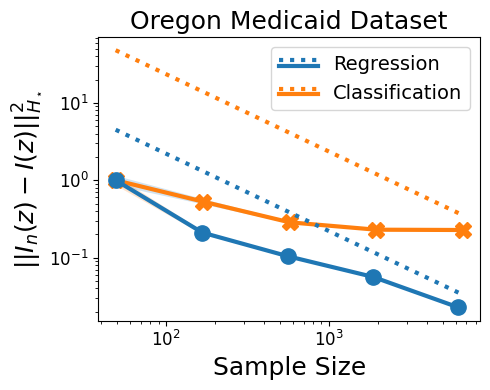

In [8]:
# Graph Results
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase


class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0, y0+width], [0.7*height, 0.7*height],
                        linestyle=orig_handle[1], color=orig_handle[2])
        l2 = plt.Line2D([x0, y0+width], [0.3*height, 0.3*height],
                        color=orig_handle[0])
        return [l1, l2]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
ax.plot(n_ls_hg_final, results_total_mean_hg, label="Classification",
        color=COLORS[1], marker=shape[1], markersize=11)
ax.fill_between(n_ls_hg_final, [np.abs(m-sd/np.sqrt(n)).item() for m, sd, n in zip(results_total_mean_hg, results_total_sd_hg, n_ls_hg_final)], [
                np.abs(m+sd/np.sqrt(n)).item() for m, sd, n in zip(results_total_mean_hg, results_total_sd_hg, n_ls_hg_final)], alpha=0.2)
ax.plot(n_ls_hg_final, pd.DataFrame(48*stat_bound_ls_hg[0]/np.max(stat_bound_ls_hg[0]))[
        0:5], color=COLORS[1], markersize=11, linestyle=line[1], label="Classification")
ax.plot(n_ls_gd_final, results_total_mean_gd, label="Regression",
        color=COLORS[0], marker=shape[0], markersize=11, linestyle=line[0])
ax.fill_between(n_ls_gd_final, [np.abs(m-sd/np.sqrt(n)).item() for m, sd, n in zip(results_total_mean_gd, results_total_sd_gd, n_ls_gd_final)], [
                np.abs(m+sd/np.sqrt(n)).item() for m, sd, n in zip(results_total_mean_gd, results_total_sd_gd, n_ls_gd_final)], alpha=0.2)
ax.plot(n_ls_gd_final, pd.DataFrame(4.5*stat_bound_ls_gd[0]/np.max(
    stat_bound_ls_gd[0]))[0:5], color=COLORS[0], markersize=11, linestyle=line[1])
ax.set_ylabel(r'$|| I_{n}(z) - I(z) ||_{H_\star}^2$')
ax.set_xlabel("Sample Size")
ax.set_title('Oregon Medicaid Dataset')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend([(COLORS[0], line[1], COLORS[0]), (COLORS[1], line[1], COLORS[1])], ['Regression', "Classification"],
          handler_map={tuple: AnyObjectHandler()})

plt.tight_layout()
